**Goal:** Explore and visualize different positional encoding methods and their impact on the attention mechanism.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

torch.manual_seed(0)

Toy sequence: identical tokens

In [2]:
seq_len = 10
d_model = 6   # small so we can visualize
tokens = torch.zeros(seq_len, d_model)
positions = torch.arange(seq_len)

Four positional encoding methods

In [3]:
# 1. Classic sinusoidal
def sinusoidal_pe(seq_len, d):
    pe = torch.zeros(seq_len, d)
    pos = torch.arange(seq_len).unsqueeze(1)
    div = torch.exp(torch.arange(0, d, 2) * (-np.log(10000) / d))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe

pe_sin = sinusoidal_pe(seq_len, d_model)

In [4]:
#2. Learned positional embeddings
learned_pe = nn.Embedding(seq_len, d_model)
pe_learned = learned_pe(positions)

In [5]:
#3. RoPE (rotary positional embedding)
def rope(x):
    d = x.size(-1)
    freqs = torch.exp(-np.log(10000) * torch.arange(0, d, 2) / d)
    angles = positions[:, None] * freqs[None, :]
    sin, cos = torch.sin(angles), torch.cos(angles)

    x1 = x[:, 0::2]
    x2 = x[:, 1::2]
    return torch.cat([x1 * cos - x2 * sin,
                      x1 * sin + x2 * cos], dim=-1)

pe_rope = rope(tokens + 1.0)

In [6]:
#4. ALiBi (attention bias only)
def alibi_bias(seq_len, slope=1.0):
    bias = torch.zeros(seq_len, seq_len)
    for i in range(seq_len):
        for j in range(seq_len):
            bias[i, j] = -abs(i - j) * slope
    return bias

alibi = alibi_bias(seq_len)

3D visualization: “position becomes geometry”

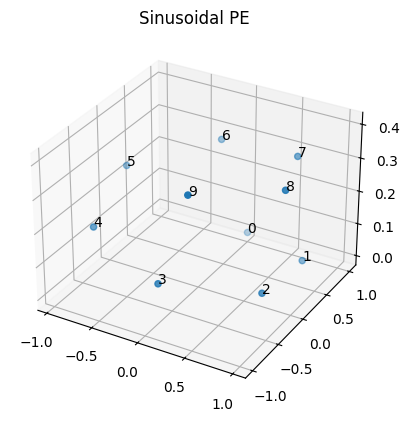

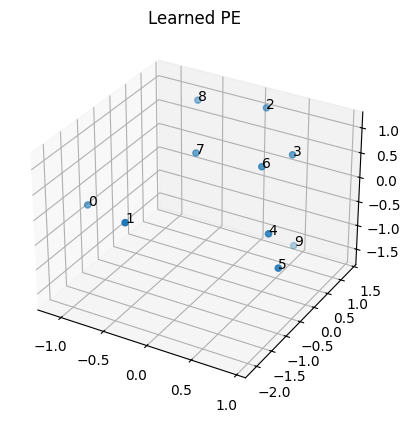

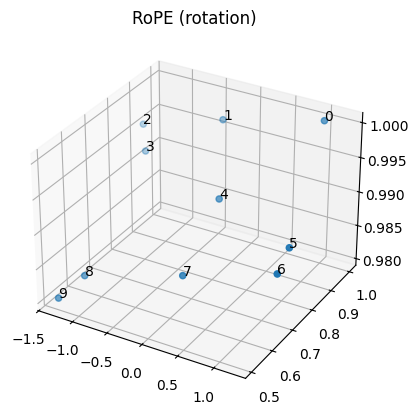

In [7]:
def plot_3d(pe, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pe[:,0], pe[:,1], pe[:,2])
    for i in range(len(pe)):
        ax.text(pe[i,0], pe[i,1], pe[i,2], str(i))
    ax.set_title(title)
    plt.show()

plot_3d(pe_sin, "Sinusoidal PE")
plot_3d(pe_learned.detach(), "Learned PE")
plot_3d(pe_rope.detach(), "RoPE (rotation)")

Ablation: remove positions → watch attention collapse

In [10]:
def attention(q, k):
    scores = q @ k.T
    return torch.softmax(scores, dim=-1)

In [11]:
#1. Without positional information
attn_no_pos = attention(tokens, tokens)

In [12]:
#2. With positional encoding
attn_with_pos = attention(tokens + pe_sin, tokens + pe_sin)

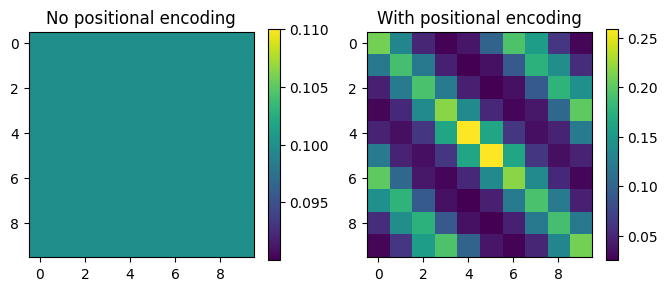

In [13]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(attn_no_pos)
plt.title("No positional encoding")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(attn_with_pos)
plt.title("With positional encoding")
plt.colorbar()

plt.show()

Notebook Summary

**Achieved:**

* Implemented and visualized four positional encoding techniques: Sinusoidal, Learned, RoPE (Rotary Positional Embedding), and ALiBi (Attention with Linear Biases).
*  Demonstrated how positional encoding enables the attention mechanism to differentiate between tokens in a sequence.

**Result:** Positional encoding transforms token positions into unique geometric representations, allowing the attention mechanism to understand sequence order, which is not possible with identical tokens without such encoding.